## Example 2: Logistic regression

Import libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

Read data

In [3]:
data = bmb.load_data("ANES")
print(data.shape)
data.head()

(421, 3)


,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Subset data

In [4]:
data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
print(data.shape)
data.head()

(373, 3)


,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Fit model

In [5]:
model = bmb.Model("vote[clinton] ~ party_id + party_id:age", data, family="bernoulli")
model

Formula: vote[clinton] ~ party_id + party_id:age
Family name: Bernoulli
Link: logit
Observations: 373
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3846)
    party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
    party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0938 0.1007 0.1098])


In [6]:
idata = model.fit(tune=2000, draws=2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, party_id:age, party_id]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


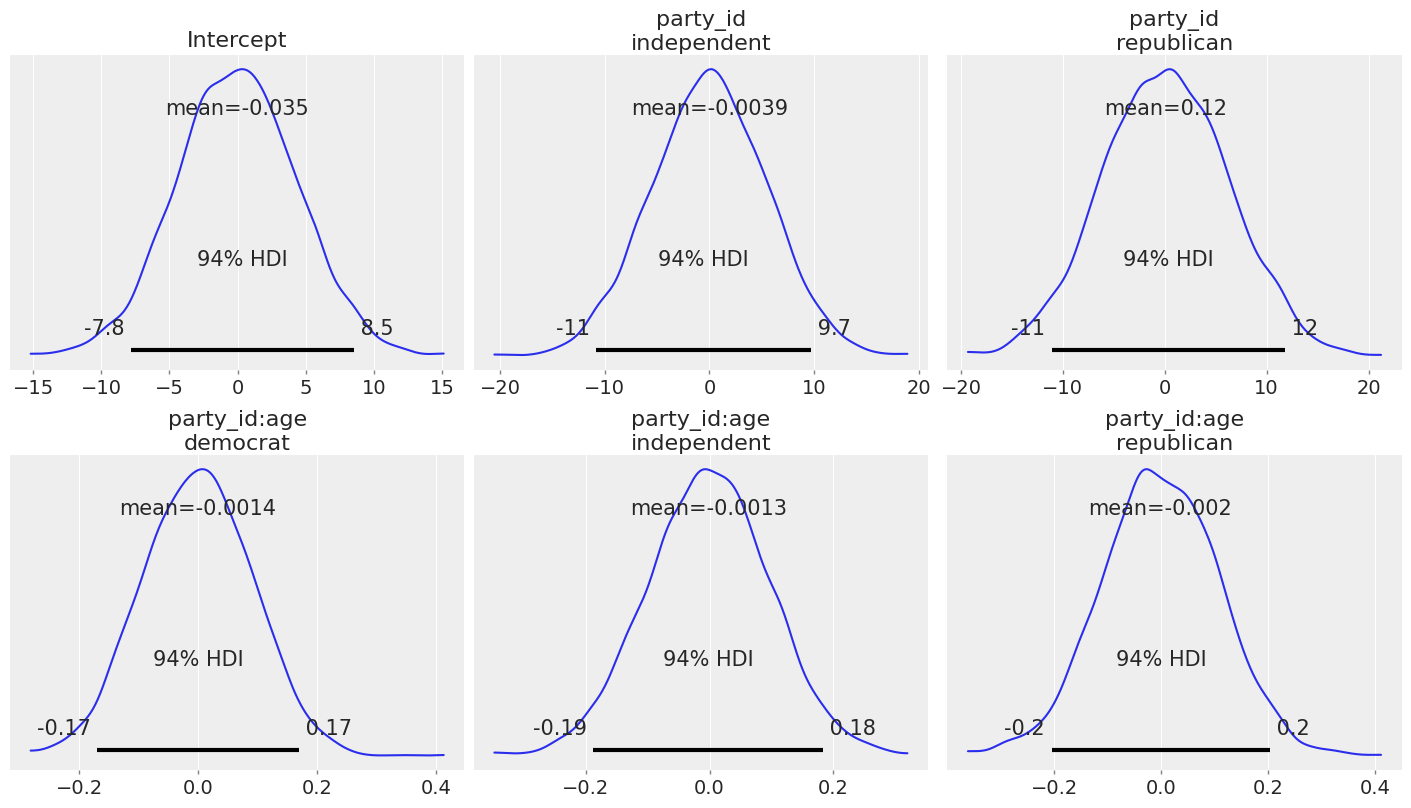

In [7]:
model.plot_priors(figsize = (14, 8));
plt.savefig("imgs/clinton_prior.png")

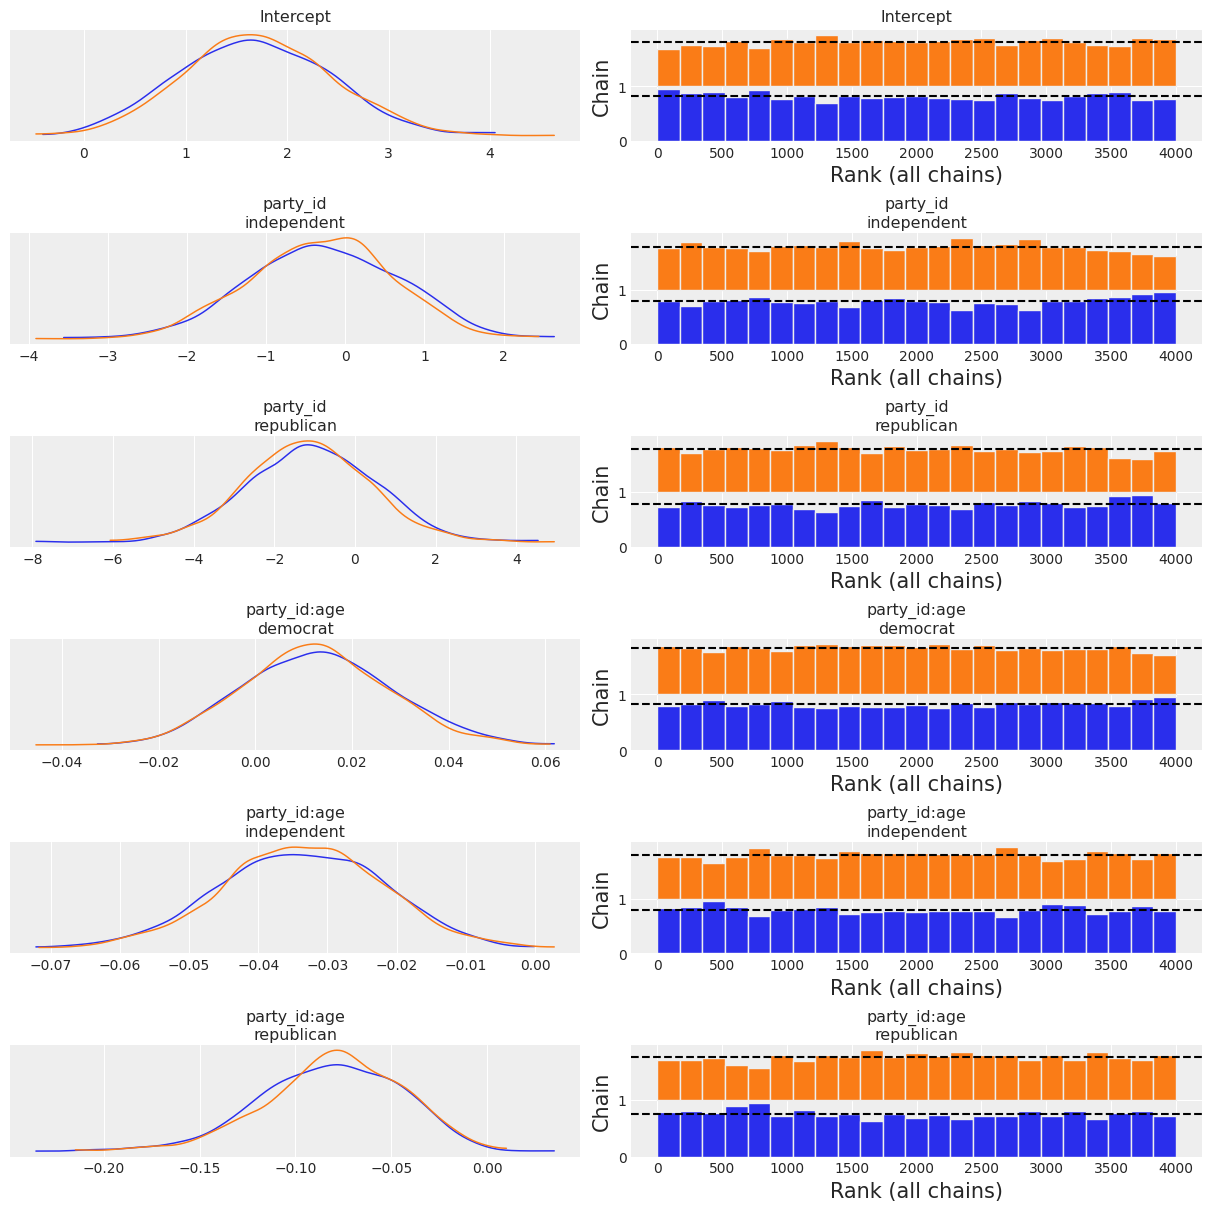

In [8]:
az.plot_trace(idata, compact=False, kind="rank_bars");
plt.savefig("imgs/clinton_posterior.png")

In [9]:
# We need to automatically add labels to InferenceData object to recover this by_label selection
parties = ["democrat", "independent", "republican"]
party_idx = [0, 1, 2]
dem, ind, rep = [idata.posterior["party_id:age"][:, :, x].values for x in party_idx]

In [10]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(["democrat", "republican", "independent"], len(age))
})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


In [11]:
model.predict(idata, data=new_data)

# Compute mean across chains
posterior_mean = idata.posterior["vote_mean"].values.mean(0)

# Select 1000 draws
posterior_mean = posterior_mean[:1000, :]

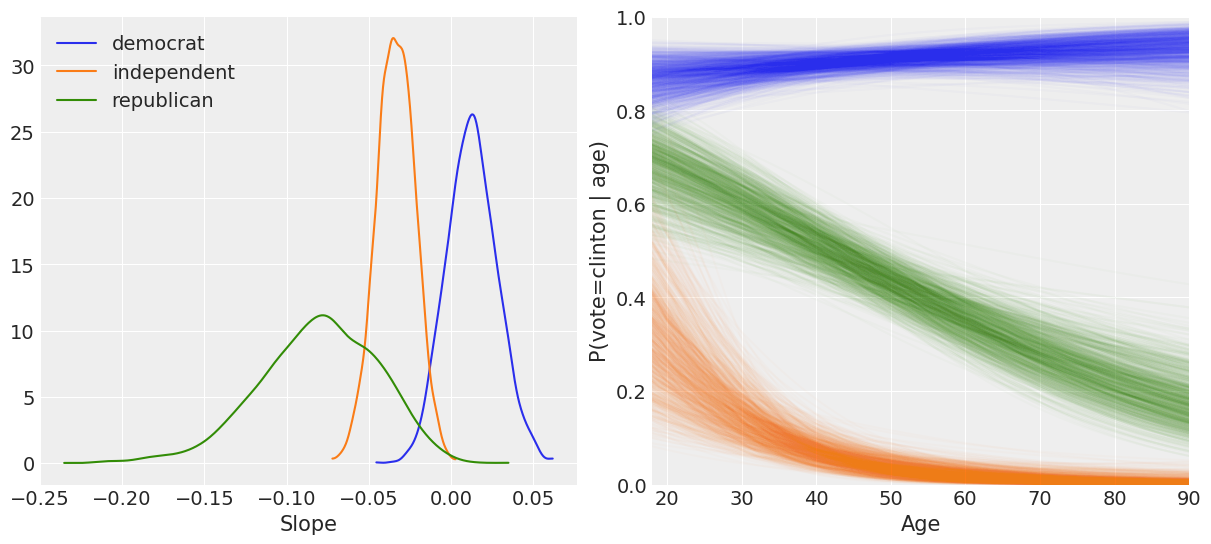

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5.33))

for idx, x in enumerate([dem, ind, rep]):
    az.plot_kde(x, label=f"{parties[idx]}", plot_kwargs={"color": f"C{idx}"}, ax=ax[0])

ax[0].legend(loc="upper left")
ax[0].set_xlabel("Slope")

for i, party in enumerate(["democrat", "republican", "independent"]):
    idx = new_data.index[new_data["party_id"] == party].tolist()
    ax[1].plot(age, posterior_mean[:, idx].T, alpha=0.02, color=f"C{i}")


ax[1].set_ylabel("P(vote=clinton | age)")
ax[1].set_xlabel("Age", fontsize=15)
ax[1].set_ylim(0, 1)
ax[1].set_xlim(18, 90)
               
fig.savefig("imgs/clinton_results.png")               

In [13]:
dem = dem.ravel()
rep = rep.ravel()
ind = ind.ravel()

In [14]:
print((dem > rep).mean())

0.997


In [15]:
print((dem > ind).mean())

0.9925


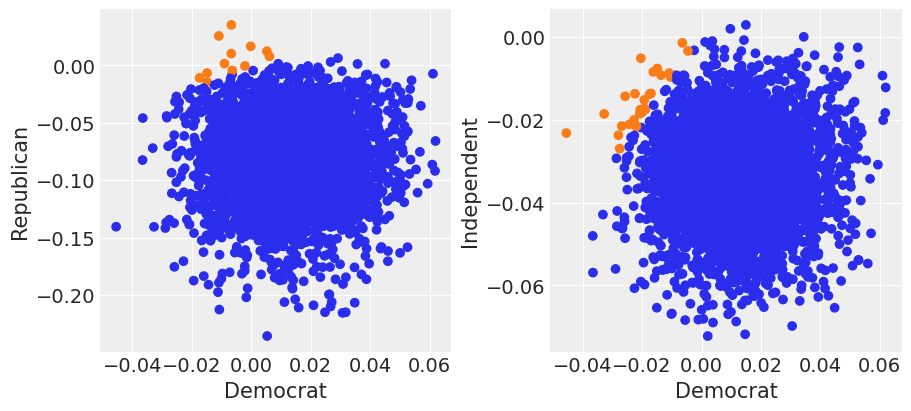

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Just grab first to colors from color map
colors = ["C0" if x > y else "C1" for x, y in zip(dem, rep)]

axes[0].scatter(dem, rep, c=colors)
axes[0].set_xlabel("Democrat")
axes[0].set_ylabel("Republican")

colors = ["C0" if x > y else "C1" for x, y in zip(dem, ind)]

axes[1].scatter(dem, ind, c=colors)
axes[1].set_xlabel("Democrat")
axes[1].set_ylabel("Independent")

fig.savefig("imgs/clinton_party_joint.png")   

## Some extra stuff

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 24 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

json      : 2.0.9
bambi     : 0.6.0
numpy     : 1.21.2
arviz     : 0.11.2
matplotlib: 3.4.3
pandas    : 1.3.1

Watermark: 2.1.0

